**Getting the Data**

In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c facial-keypoints-detection

In [0]:
!unzip \test.zip

In [0]:
!unzip \training.zip

**Importing Necessary Packages**

In [0]:
%tensorflow_version 1.x
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

TensorFlow 1.x selected.


**Preparing Data**

In [0]:
def load(file=None, cols=None):

  if file:
    df = pd.read_csv('training.csv')
  else:
    df = pd.read_csv('test.csv')

  #Image column has pixel values separated by space in form of string
  df['Image'] = df['Image'].apply(lambda pix: np.fromstring(pix, sep=' '))

  if cols:
    df = df[list(cols) + 'Image']

  #remove rows with missing values
  df = df.dropna()

  #Normalizing the input between 0 and 1
  X = np.vstack(df['Image'].values) / 255.0
  X = X.astype(np.float32)

  #Only training.csv had the output labels, so load only when we need to train
  #Normalizing the output between -1 and 1 and shuffling the input data
  if file:
    y = df[df.columns[:-1]].values
    y = (y - 48) / 48.0
    X, y = shuffle(X, y, random_state=1)
    y = y.astype(np.float32)
  
  else:
    y = None

  X = X.reshape((-1, 96, 96, 1))

  return X, y

In [0]:
train_images, train_keypoints = load('training.csv')

In [0]:
m = train_images.shape[0]
train_images.shape

(2140, 96, 96, 1)

**To plot the augmented data**

In [0]:
def plotSample(image, keypoints, axis, title=None):
  image = image.reshape((96,96))
  axis.imshow(image, cmap='gray')
  axis.scatter(keypoints[::2] * 48 + 48, keypoints[1::2] * 48 + 48, marker='o', s=10)
  axis.title.set_text(title)

**Check the loaded data**

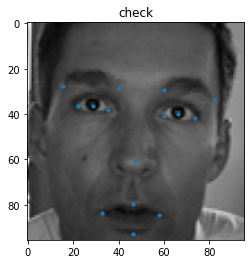

In [0]:
fig, axis = plt.subplots()
plotSample(train_images[0], train_keypoints[0], axis, "check")

#**Augmentation Functions**

**Horizontal Flip**

In [0]:
def Flip(images, keypoints, horizontal=True):
  '''
  Info-
    To flip the images horizontally or vertically and return the produced output

  Arguements-
    images: array, images to be flipped horizontally(shape = (no of images, rows, cols, channels))
    keypoints: array, position of the landmark for the provided images
    horizontal: boolean parameter, wether to flip horizontally or vertically, defaults to horizontal flip

  Returns-
    tuple containing flipped images and flipped keypoints
  '''

  flipped_keypoints = []
  if horizontal:
    #columnwise flip (horizontal flip)
    flipped_images = np.flip(images, axis=2)

    for points in keypoints:
      #change only X-coordinates and preserve the Y-coordinates
      flipped_keypoints.append([-p if i % 2 == 0 else p for i,p in enumerate(points)])

  else:
    #rowwise flip images(vertical flip)
    flipped_images = np.flip(images, axis=1)
    
    for points in keypoints:
      #change only Y-coordinates and preserve the X-coordinates
      flipped_keypoints.append([-p if i % 2 != 0 else p for i,p in enumerate(points)])

  flipped_keypoints = np.array(flipped_keypoints)

  return (flipped_images, flipped_keypoints)

In [0]:
H_flipped_images, H_flipped_keypoints = Flip(train_images, train_keypoints)

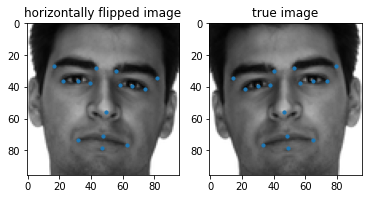

In [0]:
fig, axis = plt.subplots(1,2)
check_image = 20
plotSample(H_flipped_images[check_image], H_flipped_keypoints[check_image], axis[0], "horizontally flipped image")
plotSample(train_images[check_image], train_keypoints[check_image], axis[1], "true image")

In [0]:
V_flipped_images, V_flipped_keypoints = Flip(train_images, train_keypoints, False)

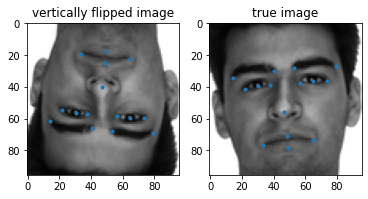

In [0]:
fig, axis = plt.subplots(1,2)
check_image = 20
plotSample(V_flipped_images[check_image], V_flipped_keypoints[check_image], axis[0], "vertically flipped image")
plotSample(train_images[check_image], train_keypoints[check_image], axis[1], "true image")

**Rotate Images**

In [0]:
def rotate(images, keypoints, rotation_angles):
  '''
  Info-
    Can rotate the input images upto 30 degrees without losing the location of the keypoints
    2 images are produced per input image and rotation angle, 
      number of rotation angles is 2
      number of images is m,
      then the number of output images are (2 * m) * 2 - 2 images per image and angle

  Arguements-
    images: array, images to be rotated clockwise
    keypoints: array, position of the landmark for the provided images
    rotation_angles: list of floats, representing the rotation angles

  Returns-
      tuple containing images rotated both clockwise and counter clockwise and converted keypoints
  '''

  rotated_images = []
  rotated_keypoints = []

  images = images * 255.0
  keypoints = keypoints * 48.0 + 48.0

  for angle in rotation_angles:
    for ang in [-angle, angle]:
      #get the center point of the image around which the image is to be rotated (48,48) is the center of the images
      #positive angle is counter clockwise and negative angle is clockwise conventionally but in cv2, opposite is true

      M = cv2.getRotationMatrix2D((48,48), ang, 1.0) #1.0 is the scaling factor
      angle_rad = -ang * np.pi / 180.0

      for image,points in zip(images,keypoints):
        #flags/interpolation: to fill the missing data in the image (inter_cubic, inter_linear and inter_area are good choices here)
        img = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_AREA)

        #subtract the value of the rotation point
        rotated_keypoint = points - 48.

        for i in range(0,len(rotated_keypoint),2):
          rotated_keypoint[i] = rotated_keypoint[i] * np.cos(angle_rad) - rotated_keypoint[i+1] * np.sin(angle_rad)
          rotated_keypoint[i+1] = rotated_keypoint[i] * np.sin(angle_rad) + rotated_keypoint[i+1] * np.cos(angle_rad)
        
        #adding the previously subtracted value
        rotated_keypoint += 48.
        rotated_keypoint = np.array(rotated_keypoint)

        if np.all(rotated_keypoint >= 0.0) and np.all(rotated_keypoint <= 96.0):
          rotated_images.append(img)
          rotated_keypoints.append(rotated_keypoint)


  rotated_images = np.array(rotated_images)
  rotated_images = rotated_images.reshape((-1,96,96,1))
  rotated_images = rotated_images / 255.
  rotated_keypoints = np.array(rotated_keypoints)
  rotated_keypoints = (rotated_keypoints - 48.) / 48.

  return (rotated_images, rotated_keypoints)

In [0]:
rotation_angles = [15.0]
rotated_images, rotated_keypoints = rotate(train_images, train_keypoints, rotation_angles)
#check that some images were not added due to boundary constraints
print(rotated_images.shape, train_images.shape)

(4276, 96, 96, 1) (2140, 96, 96, 1)


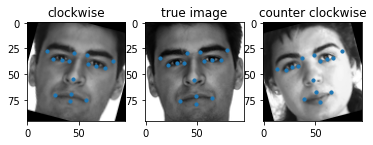

In [0]:
fig, axis = plt.subplots(1,3)
check_image = 20
plotSample(rotated_images[check_image], rotated_keypoints[check_image], axis[0], "clockwise")
plotSample(train_images[check_image], train_keypoints[check_image], axis[1], "true image")
plotSample(rotated_images[2140+check_image], rotated_keypoints[2140+check_image], axis[2], "counter clockwise")

**Brightness Alteration**

In [0]:
def alter_brightness(images, keypoints, B=True, D=False, brighten=1.2, dampen=0.6):
  '''
  Info-
    To alter the brightness of the input images and return the results based on the preferred input

  Arguements-
    images: array, images to be brighten or dampen
    keypoints: array, landmark positions of the corresponding images
    B: boolean parameter, if needs brightness
    D: boolean parameter, if needs dampness
    brighten: float, factor by which to increase brightness, greater than 1
    dampen: float, factor by which to decrease brightness, less than 1

  returns-
    tuple of altered images and corresponding keypoints
  '''

  assert brighten > 1 and dampen < 1
  assert B or D

  altered_images = []

  if B:
    brightened_images = np.clip(images*brighten, 0.0, 1.0)
    altered_images.extend(brightened_images)
  if D:
    damped_images = np.clip(images*dampen, 0.0, 1.0)
    altered_images.extend(damped_images)

  return altered_images, np.concatenate((keypoints,keypoints))

In [0]:
B = True
D = True
altered_images, altered_keypoints = alter_brightness(train_images, train_keypoints, B, D, 1.2, 0.1)

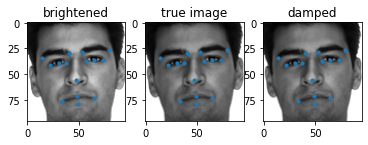

In [0]:
if B and D:
  fig, axis = plt.subplots(1,3)
else:
  fig, axis = plt.subplots(1,2)
check_image = 20

if B and D:
  plotSample(altered_images[check_image], altered_keypoints[check_image], axis[0], "brightened")
  plotSample(train_images[check_image], train_keypoints[check_image], axis[1], "true image")
  plotSample(altered_images[2140+check_image], altered_keypoints[2140+check_image], axis[2], "damped")

elif B:
  plotSample(altered_images[check_image], altered_keypoints[check_image], axis[0], "brightened")
  plotSample(train_images[check_image], train_keypoints[check_image], axis[1], "true image")

else:
  plotSample(altered_images[check_image], altered_keypoints[check_image], axis[0], "damped")
  plotSample(train_images[check_image], train_keypoints[check_image], axis[1], "true image")

**Shifting**

In [0]:
def shiftImage(images, keypoints, shifts=[]):
  '''
  Info-
    To shift the images upwards, downwards, left and right to make the dominant features shift places and return the shifted images

  Arguements:
    images: array, images to be shifted
    keypoints: array, keypoints to be converted
    shifts: list of positive ints, pixels by which to shift the image features, defaults to []

  Returns-
    tuple of the shifted images and the converted keypoints
  '''

  shifted_images = []
  shifted_keypoints = []

  keypoints = keypoints * 48. + 48.

  for shift in shifts:
    for (shift_x,shift_y) in [(shift,shift), (-shift,shift), (shift,-shift), (-shift,-shift)]:
      M = np.float32([
                      [1,0,shift_x],
                      [0,1,shift_y]
                    ])
      
      for image,keypoint in zip(images,keypoints):
        shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_AREA)
        shifted_keypoint = np.array([point+shift_x if idx % 2 == 0 else point+shift_y for idx,point in enumerate(keypoint)])

        if np.all(shifted_keypoint > 0.0) and np.all(shifted_keypoint < 96.0):
          shifted_keypoints.append(shifted_keypoint)
          shifted_images.append(shifted_image)

  shifted_images = np.array(shifted_images)
  shifted_keypoints = np.array(shifted_keypoints)
  shifted_keypoints = (shifted_keypoints - 48.) / 48.
  
  return (shifted_images, shifted_keypoints)

In [0]:
shifted_images, shifted_keypoints = shiftImage(train_images, train_keypoints, [12])
#check that some images were not added due to boundary constraints
print(shifted_images.shape, train_images.shape)

(6350, 96, 96) (2140, 96, 96, 1)


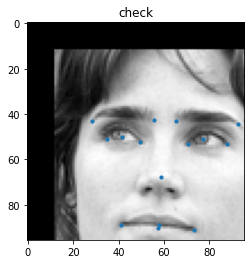

In [0]:
fig, axis = plt.subplots()
check_image = 20
plotSample(shifted_images[check_image], shifted_keypoints[check_image], axis, "check")

**Noise Augmentation**

In [0]:
def addNoise(images, noise_scale=0.01):
  '''
  Info-
    To add random noise in the image

  Arguements:
    images: array, images in which noise is to be introduced
    noise_scale: float, scales down the added noise, defaults to 0.01

  Returns-
    array of noisy images
  '''

  noisy_images = []

  for image in images:
    noise = noise_scale*np.random.randn(96,96,1)
    noisy_image = noise + image
    noisy_image = np.clip(noisy_image, 0.0, 1.0)
    noisy_images.append(noisy_image)

  noisy_images = np.array(noisy_images)
  
  return noisy_images

In [0]:
noisy_images = addNoise(train_images, 0.1)
noisy_keypoints = train_keypoints

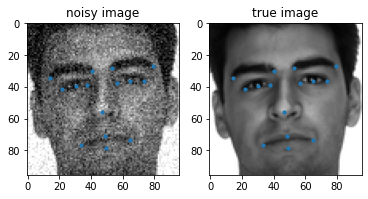

In [0]:
fig, axis = plt.subplots(1,2)
check_image = 20
plotSample(noisy_images[check_image], noisy_keypoints[check_image], axis[0], "noisy image")
plotSample(train_images[check_image], train_keypoints[check_image], axis[1], "true image")